In [1]:
import pandas as pd
from tqdm.auto import tqdm
import actions
from pathlib import Path
from utils import *
import re
from tqdm.auto import tqdm
import json

C:\Users\voelk\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define the file paths
parquet_file_abcd = Path("../data/ABCD_tripfiles.parquet")
parquet_file_abcd_conv = Path("../data/ABCD_tripfiles_conv.parquet")
parquet_file_mnop = Path("../data/MNOP_tripfiles.parquet")
parquet_file_mnop_conv = Path("../data/MNOP_tripfiles_conv.parquet")
parquet_file_zyxw = Path("../data/ZYXW_tripfiles.parquet")
parquet_file_zyxw_conv = Path("../data/ZYXW_tripfiles_conv.parquet")
print(
    parquet_file_abcd,
    parquet_file_abcd_conv,
    parquet_file_mnop,
    parquet_file_mnop_conv,
    parquet_file_zyxw,
    parquet_file_zyxw_conv,
)

..\data\ABCD_tripfiles.parquet ..\data\ABCD_tripfiles_conv.parquet ..\data\MNOP_tripfiles.parquet ..\data\MNOP_tripfiles_conv.parquet ..\data\ZYXW_tripfiles.parquet ..\data\ZYXW_tripfiles_conv.parquet


In [3]:
df_abcd = pd.read_parquet(parquet_file_abcd)
df_mnop = pd.read_parquet(parquet_file_mnop)
df_zyxw = pd.read_parquet(parquet_file_zyxw)

In [4]:
print(round(df_abcd.memory_usage(deep=True).sum() / 1024**2, 2), "MB")
print(round(df_mnop.memory_usage(deep=True).sum() / 1024**2, 2), "MB")
print(round(df_zyxw.memory_usage(deep=True).sum() / 1024**2, 2), "MB")

1214.94 MB
2219.62 MB
585.54 MB


In [5]:
action_names = set(df_abcd.action_name.unique())
print(len(action_names))
action_names.update(set(df_mnop.action_name.unique()))
print(len(action_names))
action_names.update(set(df_zyxw.action_name.unique()))
print(len(action_names))

49
62
67


In [6]:
from actions import (
    CalculateWeightAndTrimAction,
    CheckinMsgProcessor,
    EstimateStorePaxDataAction,
    SendFuelOrderAction,
    SendLoadingInstructionAction,
    SendLoadsheetAction,
    SetActualBagWeightIndicatorAction,
    SetCKIPaxDistributionAction,
    StoreAircraftDataAction,
    StorePaxDataAction,
    StoreRegistrationAndConfigurationAc,
    TdmCreateLoadingInstructionAction,
    CreateZFWMessageAction,
    UpdateFuelDataAction,
    RampFinalAction,
    CreateLoadingInstructionAction,
    EstimateStorePaxDataAction,
    TransferCargoAction,
    TransferCheckinDataAction,
    UpdateEstimatesAction,
    UpdateLoadTableAction,
)

In [10]:
action_extractors = {
    "CalculateWeightAndTrimAction": CalculateWeightAndTrimAction.extract,
    "CheckinMsgProcessor": CheckinMsgProcessor.extract,
    # TODO "CreateLoadsheetAction": CreateLoadsheetAction.extract, # missing
    "CreateZFWMessageAction": CreateZFWMessageAction.extract,
    "SendFuelOrderAction": SendFuelOrderAction.extract,
    "SendLoadsheetAction": SendLoadsheetAction.extract,
    "SetActualBagWeightIndicatorAction": SetActualBagWeightIndicatorAction.extract,
    "StorePaxDataAction": StorePaxDataAction.extract,
    "StoreRegistrationAndConfigurationAc": StoreRegistrationAndConfigurationAc.extract,
    "UpdateFuelDataAction": UpdateFuelDataAction.extract,
    "RampFinalAction": RampFinalAction.extract,
    "CreateLoadingInstructionAction": CreateLoadingInstructionAction.extract,
    "EstimateStorePaxDataAction": EstimateStorePaxDataAction.extract,
    "SendLoadingInstructionAction": SendLoadingInstructionAction.extract,
    "SetCKIPaxDistributionAction": SetCKIPaxDistributionAction.extract,
    # TODO "SpecialPaxWeightAction": SpecialPaxWeightAction.extract, # missing
    # TODO "StoreAircraftDataAction": StoreAircraftDataAction.extract, # BUG
    "StorePaxDataGuiAction": StorePaxDataAction.extract,
    "TdmCreateLoadingInstructionAction": TdmCreateLoadingInstructionAction.extract,
    "TransferCargoAction": TransferCargoAction.extract,
    "TransferCheckinDataAction": TransferCheckinDataAction.extract,
    "UpdateEstimatesAction": UpdateEstimatesAction.extract,
    "UpdateLoadTableAction": UpdateLoadTableAction.extract,
    # TODO "UpdateTransitLoadTableAction": UpdateTransitLoadTableAction.extract,
}

In [12]:
from concurrent.futures import ThreadPoolExecutor

In [ ]:
print("ABCD")
df_abcd_conv = extract_df(df_abcd)
df_abcd_conv.to_parquet(parquet_file_abcd_conv, engine="pyarrow", compression="brotli")
print("MNOP")
df_mnop_conv = extract_df(df_mnop)
df_mnop_conv.to_parquet(parquet_file_mnop_conv, engine="pyarrow", compression="brotli")
print("ZYXW")
df_zyxw_conv = extract_df(df_zyxw)
df_zyxw_conv.to_parquet(parquet_file_zyxw_conv, engine="pyarrow", compression="brotli")

In [13]:
def extract_df(df: pd.DataFrame):
    tqdm.pandas()
    for action_name, extractor in action_extractors.items():

        if extractor is not None:
            print(action_name)

            df[f"data_{action_name}"] = df[df.action_name == action_name][
                "entry_details"
            ].progress_apply(extractor)
    return df


def process_data(df, file_path, label):
    print(label)
    df_conv = extract_df(df)
    df_conv.to_parquet(file_path, engine="pyarrow", compression="brotli")


# Create a ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=3) as executor:
    futures = [
        executor.submit(process_data, df_abcd, parquet_file_abcd_conv, "ABCD"),
        executor.submit(process_data, df_mnop, parquet_file_mnop_conv, "MNOP"),
        executor.submit(process_data, df_zyxw, parquet_file_zyxw_conv, "ZYXW"),
    ]

    # Optional: Wait for all futures to complete
    for future in futures:
        future.result()  # This will re-raise any exceptions that occurred during task execution


# print("ABCD")
# df_abcd_conv = extract_df(df_abcd)
# df_abcd_conv.to_parquet(parquet_file_abcd_conv, engine="pyarrow", compression="brotli")
# print("MNOP")
# df_mnop_conv = extract_df(df_mnop)
# df_mnop_conv.to_parquet(parquet_file_mnop_conv, engine="pyarrow", compression="brotli")
# print("ZYXW")
# df_zyxw_conv = extract_df(df_zyxw)
# df_zyxw_conv.to_parquet(parquet_file_zyxw_conv, engine="pyarrow", compression="brotli")

ABCD
MNOP
ZYXW
CalculateWeightAndTrimAction
CalculateWeightAndTrimAction
CalculateWeightAndTrimAction


 64%|██████▍   | 84485/131682 [00:19<00:08, 5730.82it/s]

100%|██████████| 131682/131682 [00:28<00:00, 4607.74it/s]






CheckinMsgProcessor


100%|██████████| 260/260 [00:00<00:00, 2232.39it/s]





CreateZFWMessageAction



 93%|█████████▎| 16731/17969 [00:00<00:00, 38559.68it/s]

100%|██████████| 17969/17969 [00:00<00:00, 26863.74it/s]




SendFuelOrderAction



  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 31.39it/s]





SendLoadsheetAction


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 10.59it/s]





SetActualBagWeightIndicatorAction


 53%|█████▎    | 6181/11572 [00:00<00:00, 61518.48it/s]

100%|██████████| 11572/11572 [00:00<00:00, 30331.51it/s]






StorePaxDataAction


 99%|█████████▉| 18149/18373 [00:04<00:00, 4023.98it/s]

100%|██████████| 18373/18373 [00:04<00:00, 4070.25it/s]




StoreRegistrationAndConfigurationAc




 81%|████████  | 15865/19548 [00:00<00:00, 158380.16it/s]

100%|██████████| 19548/19548 [00:00<00:00, 50691.78it/s] 





UpdateFuelDataAction


  0%|          | 0/125 [00:00<?, ?it/s]

100%|██████████| 125/125 [00:00<00:00, 646.68it/s]





RampFinalAction


  0%|          | 0/65 [00:00<?, ?it/s]

100%|██████████| 65/65 [00:00<00:00, 336.27it/s]





CreateLoadingInstructionAction


  0%|          | 0/129 [00:00<?, ?it/s]

100%|██████████| 129/129 [00:00<00:00, 668.37it/s]




EstimateStorePaxDataAction



  0%|          | 0/8681 [00:00<?, ?it/s]

100%|██████████| 8681/8681 [00:00<00:00, 72532.25it/s]





SendLoadingInstructionAction


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 10.02it/s]





SetCKIPaxDistributionAction


 87%|████████▋ | 202840/231990 [00:40<00:02, 11918.55it/s]

 91%|█████████ | 10572/11598 [00:00<00:00, 32487.29it/s]

100%|██████████| 11598/11598 [00:00<00:00, 19697.60it/s]





StorePaxDataGuiAction


  0%|          | 0/42 [00:00<?, ?it/s]

100%|██████████| 42/42 [00:00<00:00, 212.29it/s]





TdmCreateLoadingInstructionAction


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 30.13it/s]






TransferCargoAction


 93%|█████████▎| 11665/12564 [00:00<00:00, 13285.30it/s]

100%|██████████| 12564/12564 [00:01<00:00, 11562.11it/s]



CheckinMsgProcessor
TransferCheckinDataAction



0it [00:00, ?it/s]
0it [00:00, ?it/s]




UpdateEstimatesAction




0it [00:00, ?it/s]
0it [00:00, ?it/s]





UpdateLoadTableAction



 92%|█████████▏| 3715/4038 [00:00<00:00, 4912.47it/s]

100%|██████████| 4038/4038 [00:00<00:00, 4215.38it/s]


















100%|██████████| 133782/133782 [00:04<00:00, 28995.25it/s]





CreateZFWMessageAction



100%|██████████| 5005/5005 [00:00<00:00, 35279.90it/s]




SendFuelOrderAction



0it [00:00, ?it/s]
0it [00:00, ?it/s]




SendLoadsheetAction



100%|██████████| 14/14 [00:00<00:00, 239.85it/s]




SetActualBagWeightIndicatorAction



100%|██████████| 1978/1978 [00:00<00:00, 26182.47it/s]




 39%|███▉      | 150129/381100 [00:50<00:28, 8190.68it/s]

StorePaxDataAction



100%|█████████▉| 150420/150871 [00:40<00:00, 4371.51it/s]

100%|██████████| 150871/150871 [00:40<00:00, 3726.16it/s]







StoreRegistrationAndConfigurationAc


100%|██████████| 8036/8036 [00:00<00:00, 86027.56it/s]






UpdateFuelDataAction


100%|██████████| 3583/3583 [00:00<00:00, 28759.78it/s]




RampFinalAction



100%|██████████| 3804/3804 [00:00<00:00, 31148.50it/s]







CreateLoadingInstructionAction


100%|██████████| 6408/6408 [00:00<00:00, 13339.20it/s]


CheckinMsgProcessor
EstimateStorePaxDataAction


 28%|██▊       | 36764/130854 [00:00<00:00, 99716.65it/s] 

SendLoadingInstructionAction


 62%|██████▏   | 81090/130854 [00:00<00:00, 96638.11it/s] 

SetCKIPaxDistributionAction


0it [00:00, ?it/s]05465/130854 [00:01<00:00, 108659.49it/s]
100%|██████████| 130854/130854 [00:01<00:00, 104344.62it/s]


StorePaxDataGuiAction


 41%|████      | 652/1592 [00:00<00:00, 6104.03it/s]

CreateZFWMessageAction


  0%|          | 0/27703 [00:00<?, ?it/s]

TdmCreateLoadingInstructionAction


0it [00:00, ?it/s]644/27703 [00:00<00:00, 44861.64it/s]
 90%|████████▉ | 24815/27703 [00:00<00:00, 47913.90it/s]

TransferCargoAction


100%|██████████| 2086/2086 [00:00<00:00, 10786.97it/s]


SendFuelOrderAction


100%|██████████| 4054/4054 [00:00<00:00, 115891.44it/s]

TransferCheckinDataAction



 52%|█████▏    | 3453/6586 [00:00<00:00, 16536.34it/s]

SendLoadsheetAction


100%|██████████| 6586/6586 [00:00<00:00, 17433.55it/s]


UpdateEstimatesAction
SetActualBagWeightIndicatorAction


0it [00:00, ?it/s]
100%|██████████| 1870/1870 [00:00<00:00, 7785.59it/s] 


StorePaxDataAction
UpdateLoadTableAction


100%|██████████| 221618/221618 [00:38<00:00, 5823.67it/s]


StoreRegistrationAndConfigurationAc


100%|██████████| 3981/3981 [00:00<00:00, 69132.59it/s]


UpdateFuelDataAction


100%|██████████| 4845/4845 [00:00<00:00, 103402.60it/s]


RampFinalAction


100%|██████████| 5612/5612 [00:00<00:00, 40527.82it/s]

CreateLoadingInstructionAction



100%|██████████| 2405/2405 [00:00<00:00, 6913.83it/s]


EstimateStorePaxDataAction


100%|██████████| 4633/4633 [00:00<00:00, 840420.83it/s]


SendLoadingInstructionAction


100%|██████████| 96/96 [00:00<00:00, 4086.11it/s]

SetCKIPaxDistributionAction



0it [00:00, ?it/s]


StorePaxDataGuiAction


100%|██████████| 1912/1912 [00:00<00:00, 6972.18it/s]


TdmCreateLoadingInstructionAction


100%|██████████| 1182/1182 [00:00<00:00, 46902.75it/s]


TransferCargoAction


100%|██████████| 2496/2496 [00:00<00:00, 12853.22it/s]


TransferCheckinDataAction


100%|██████████| 78600/78600 [00:01<00:00, 40537.48it/s]


UpdateEstimatesAction


100%|██████████| 174/174 [00:00<00:00, 11984.32it/s]


UpdateLoadTableAction


100%|██████████| 35470/35470 [00:10<00:00, 3383.78it/s]


In [27]:
df = df_zyxw


x = df[
    (df.action_name == "UpdateTransitLoadTableAction")
    # & (~df["entry_details"].isnull())
    # & (
    #     ~df["entry_details"].str.contains(
    #         "com.onesystem.lc2.manualloadplanning.dto.LoadDTO", na=False
    #     )
    # ) # abcd
    # & (
    #     ~df["entry_details"].str.contains(
    #         "com.systemone.lc2.manualloadplanning.dto.LoadDTO", na=False
    #     )
    # )  # zyxw
    # & (
    #     ~df["entry_details"].str.contains("STATUS LOADING_INSTRUCTION", na=False)
    # )  # STATUS LOZYING_INSTRUCTION also included
    # & (~df["entry_details"].str.contains("STATUS LOZYING_INSTRUCTION", na=False))
    # & (
    #     ~df["entry_details"].str.contains("Email receivers", na=False)
    # )  # don't include this
    # & (
    #     ~df["entry_details"].str.contains("Telex receivers", na=False)
    # )  # don't include this
]["entry_details"].unique()

In [94]:
print(x[1])

com.systemone.lc2.manualloadplanning.dto.LoadDTO [ id = 9398702  flightId = 2293511 legId = 2404210  deleted = false  fragmentId = LoadFragment ]
ULD
 Item Id   ULD       Number    Airline   Special   Status    Weight         Pieces    Volume    Origin    Onl.Sta.  Dest.     Category  Position  Confirmed  Remarks  
 42448557  PAG       4         ZY        NULL      ESTIMATE  1482.00   KG   0         0.00      ORY       ORY       VCP       C         32P       true      PER 
 42448559  PMC       2         ZY        NULL      ESTIMATE  4000.00   KG   0         0.00      ORY       ORY       VCP       C         42P       true      PER 
 42448561  PMC       6         ZY        NULL      ESTIMATE  4000.00   KG   0         0.00      ORY       ORY       VCP       C         33P       true      PER 
 42448558  PAG       3         ZY        NULL      ESTIMATE  4000.00   KG   0         0.00      ORY       ORY       VCP       C         41P       true      PER 
 42448560  LCR       1         ZY      

In [97]:
extract(x[1])

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

In [96]:
def extract(text):
    # Normalize line breaks to just '\n' for easier processing
    normalized_text = text.replace("\r\n", "\n").strip()

    def parse_header(header):
        header_dict = {}
        matches = re.findall(r"(\w+)\s*=\s*(\S+)", header)
        for key, value in matches:
            header_dict[key] = value.strip("[]")
        return header_dict

    def parse_load(load_section, is_uld=False):
        load_data = []
        lines = load_section.strip().split("\n")[
            2:
        ]  # Skip the first two lines (headers)
        for line in lines:
            columns = re.split(r"\s{2,}", line.strip())  # Split by two or more spaces
            if len(columns) < 14:
                continue  # Skip lines that don't have enough columns

            # Ensure each field is correctly typed and handle possible misalignments
            item_dict = {
                "Item Id": columns[0] if columns[0] != "NULL" else None,
                "ULD": columns[1] if is_uld else None,
                "Number": columns[2] if columns[2] != "NULL" else None,
                "Airline": columns[3] if columns[3] != "NULL" else None,
                "Special": columns[4] if columns[4] != "NULL" else None,
                "Status": columns[5],
                "Weight": float(columns[6]) if is_float(columns[6]) else None,
                "Weight Unit": columns[7] if len(columns) > 7 else None,
                "Pieces": int(columns[8]) if is_int(columns[8]) else None,
                "Volume": float(columns[9]) if is_float(columns[9]) else None,
                "Origin": columns[10] if len(columns) > 10 else None,
                "Onl.Sta.": columns[11] if len(columns) > 11 else None,
                "Dest.": columns[12] if len(columns) > 12 else None,
                "Category": columns[13] if len(columns) > 13 else None,
                "Position": columns[14] if len(columns) > 14 else None,
                "Confirmed": (
                    columns[15].lower() == "true" if len(columns) > 15 else None
                ),
                "Remarks": (
                    columns[16] if len(columns) > 16 and columns[16] != "NULL" else None
                ),
            }
            load_data.append(item_dict)
        return load_data

    def parse_totals(totals_section):
        totals = {}
        for line in totals_section.strip().split("\n"):
            if ":" in line:
                key, value = line.split(":")
                key = key.strip()
                value = float(value.strip().split()[0])
                totals[key] = value
        return totals

    def parse_status(status_section):
        status_dict = {}
        items = re.split(r"\s+", status_section.strip())
        i = 0
        while i < len(items):
            key = items[i]
            value = items[i + 1] if (i + 1) < len(items) else None
            if is_int(value):
                value = int(value)
            status_dict[key] = value
            i += 2
        return status_dict

    def is_int(value):
        try:
            int(value)
            return True
        except ValueError:
            return False

    def is_float(value):
        try:
            float(value)
            return True
        except ValueError:
            return False

    # Use a regular expression to find the sections
    sections = re.split(r"(?=\nBULK|\nULD|\nTotal|\nSTATUS)", normalized_text)

    header_section = sections[0] if len(sections) > 0 else ""
    header_info = parse_header(header_section)

    bulk_section = next((s for s in sections if s.startswith("\nBULK")), None)
    bulk_info = parse_load(bulk_section) if bulk_section else []

    uld_section = next((s for s in sections if s.startswith("\nULD")), None)
    uld_info = parse_load(uld_section, is_uld=True) if uld_section else []

    totals_section = next((s for s in sections if s.startswith("\nTotal")), None)
    totals_info = parse_totals(totals_section) if totals_section else {}

    status_section = next((s for s in sections if s.startswith("\nSTATUS")), None)
    status_info = parse_status(status_section) if status_section else {}

    load_info = {
        "Header": header_info,
        "Bulk": bulk_info,
        "ULD": uld_info,
        "Totals": totals_info,
        "Status": status_info,
    }

    return load_info

In [ ]:
def extract(message: str):
    typos = {
        "BAG_LOZY_ITEMS_GEN": "BAG_LOAD_ITEMS_GEN",
        "LOZYING_INSTRUCTION": "LOADING_INSTRUCTION",
        "LOZYSHEET": "LOADSHEET",
    }  # Fix typos in the messages from zyxw
    for key, value in typos.items():
        message = message.replace(key, value)

    if "com.systemone.lc2.common.dto.SingleAttributeDTO" in message:
        return None
    if "STATUS LOADING_INSTRUCTION" in message:
        """ 
        Example Message: 'STATUS LOADING_INSTRUCTION 1 FUEL 2 AIRCRAFT_CONFIG 1 EZFW 1 
        CARGO_FINAL 1 CARGO_TRANSFER 1 OFP 2 CABIN_CONFIG 1 AUTO_MODE_ACTIVE 1 AUTOMATION_STARTED 0 
        BAG_LOAD_ITEMS_GEN 1 EZFW_COUNTER 1 REGISTRATION 1 REGISTRATION_CHANGE 1 FUEL_ORDER 2'
        
        All the keys are separated by a space and the values are the next element in the list.
        """
        keys = [
            "LOADING_INSTRUCTION",
            "FUEL",
            "AIRCRAFT_CONFIG",
            "EZFW",
            "CARGO_FINAL",
            "CARGO_TRANSFER",
            "OFP",
            "CABIN_CONFIG",
            "AUTO_MODE_ACTIVE",
            "AUTOMATION_STARTED",
            "BAG_LOAD_ITEMS_GEN",
            "EZFW_COUNTER",
            "REGISTRATION",
            "REGISTRATION_CHANGE",
            "FUEL_ORDER",
            "DGR_ITEMS",
            "CHECK_IN_FINAL",
            "OFFBLOCK",
            "AIRBORNE",
            "BAG_ULD_ORD",
            "CALC_HIST_DATA",
        ]

        # Initialize dictionary with None for all keys
        data = {key: None for key in keys}

        # Split the message into parts
        parts = message.split()

        # Iterate through parts and extract key-value pairs
        i = 0
        while i < len(parts):
            if parts[i] in keys:
                key = parts[i]
                if i + 1 < len(parts) and re.match(r"^-?\d+(\.\d+)?$", parts[i + 1]):
                    value = parts[i + 1]
                    data[key] = int(value)
                    i += 2
                else:
                    i += 1
            else:
                i += 1

        return  json.dumps(data)
    
    if "Telex receivers" in message or "Email receivers" in message: 
       return None #not relevant enough
    raise NotImplementedError("This message is not supported yet")

In [ ]:
tqdm.pandas()

In [ ]:
foo = df_mnop[df_mnop.action_name == "TdmCreateLoadingInstructionAction"][
    "entry_details"
].progress_apply(extract)

100%|██████████| 1182/1182 [00:00<00:00, 38129.45it/s]


In [ ]:
foo[foo.str.contains("LOADING_INSTRUCTION", na=False)].count()

394

In [ ]:
print(extract(x[0]))

{
  "Telex receivers": "ASRV1ZY",
  "Message type": "LOADING_INSTRUCTION",
  "Subject": "ZY2111/03MAY BVH-MCZ; Loading Instruction Edition 01\r",
  "Attachment file name": null,
  "Compartments": [],
  "Notes": null
}


In [ ]:
x["data_UpdateEstimatesAction"] = x[x.action_name == "UpdateEstimatesAction"][
    "entry_details"
].progress_apply(extract)

AttributeError: 'numpy.ndarray' object has no attribute 'action_name'

In [19]:
x = df_abcd.copy()

In [62]:
bar = pd.read_parquet(parquet_file_zyxw_conv)

In [47]:
bar.columns

Index(['id', 'creation_time', 'airline_code', 'flight_number', 'flight_date',
       'departure_airport', 'user_name', 'action_name', 'header_line',
       'entry_details', 'data_UpdateFuelDataAction', 'data_RampFinalAction',
       'data_CreateLoadingInstructionAction',
       'data_EstimateStorePaxDataAction', 'data_SendLoadingInstructionAction',
       'data_SetCKIPaxDistributionAction',
       'data_TdmCreateLoadingInstructionAction', 'data_UpdateEstimatesAction'],
      dtype='object')

In [50]:
filtered_data = [item for item in x if "Discrepancy check result" in item]

In [63]:
x = bar[~bar.data_SetCKIPaxDistributionAction.isna()]

In [95]:
list(x.data_SetCKIPaxDistributionAction.apply(json.loads))

[{'TOTAL Pax': 6,
  'Y': 6,
  'Jump': 0,
  'StandBy': None,
  'Male': 2,
  'Female': 2,
  'Child': 2,
  'Infant': 0,
  'Total bag': 6,
  'Total bag weight': 72.0,
  'Baggage weight type': 'HISTORIC',
  'Weight unit': 'KG',
  'Sections': {'0A': {'Capacity': 'Y72', 'Distribution': 'Y0'},
   '0C': {'Capacity': 'Y102', 'Distribution': 'Y0'}},
  'Distribution': 'CKI_DISTRIBUTION'},
 {'TOTAL Pax': None,
  'Y': 0,
  'Jump': None,
  'StandBy': None,
  'Male': None,
  'Female': None,
  'Child': None,
  'Infant': None,
  'Total bag': 0,
  'Total bag weight': 0.0,
  'Baggage weight type': 'HISTORIC',
  'Weight unit': 'KG',
  'Sections': {'0A': {'Capacity': 'Y58', 'Distribution': 'Y0'},
   '0C': {'Capacity': 'Y60', 'Distribution': 'Y0'}},
  'Distribution': 'CKI_DISTRIBUTION'},
 {'TOTAL Pax': None,
  'Y': 0,
  'Jump': None,
  'StandBy': None,
  'Male': None,
  'Female': None,
  'Child': None,
  'Infant': None,
  'Total bag': 0,
  'Total bag weight': 0.0,
  'Baggage weight type': 'HISTORIC',
  'Weig

In [132]:
list(x.data_UpdateEstimatesAction.apply(json.loads))

TypeError: the JSON object must be str, bytes or bytearray, not NoneType

In [155]:
foobar = [
    item[list(item.keys())[13]]
    for item in list(x.data_SetCKIPaxDistributionAction.apply(json.loads))
    if len(item.keys()) > 11
    # if "HISTORIC" not in item["Baggage weight type"]
]

In [137]:
import matplotlib.pyplot as plt

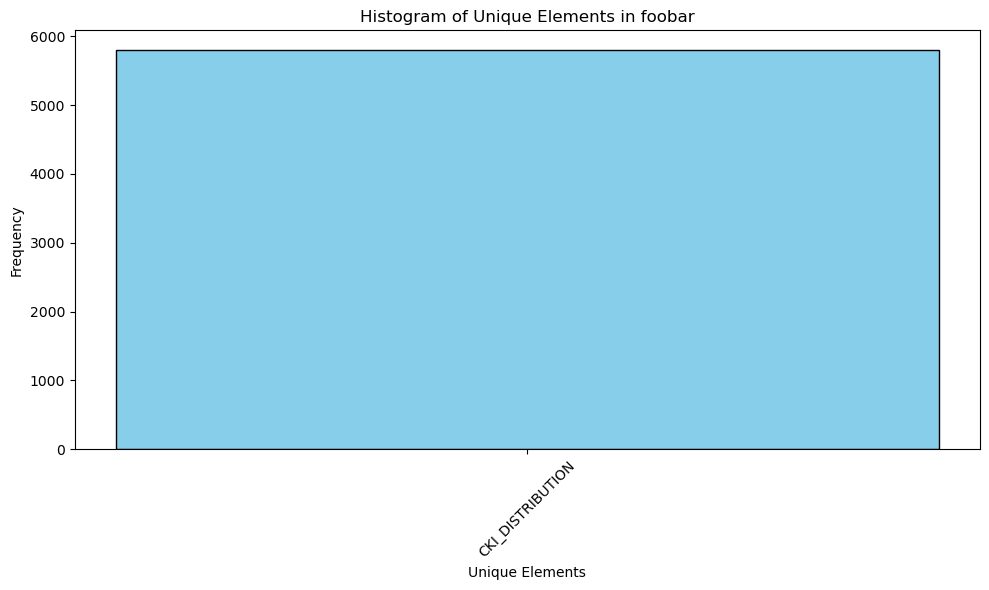

In [156]:
import matplotlib.pyplot as plt
from collections import Counter

# Sample list with mixed types
# foobar = [1, 2, 'apple', 2, 'banana', 'apple', 4, 'banana', 'carrot', 5, 6, 'apple']

# Count the frequency of each unique element
frequency = Counter(foobar)

# Extract unique elements and their counts, convert elements to strings
unique_elements = list(map(str, frequency.keys()))
counts = list(frequency.values())

# Plot the histogram (bar chart)
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.bar(unique_elements, counts, color="skyblue", edgecolor="black")

# Add titles and labels for better readability
plt.title("Histogram of Unique Elements in foobar")
plt.xlabel("Unique Elements")
plt.ylabel("Frequency")

# Rotate the x-axis labels if they overlap
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

In [135]:
set(foobar)

{0.0,
 126.0,
 144.0,
 1712.0,
 189.0,
 24.0,
 260.0,
 32.0,
 3552.0,
 357.0,
 360.0,
 3680.0,
 4000.0,
 460.0,
 4680.0,
 522.0,
 5960.0,
 60.0,
 702.0,
 72.0,
 924.0,
 'ACTUAL',
 'HISTORIC',
 'KG'}